In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.utils import (
    load_data,
    remove_duplicates_in_coloumn,
    convert_from_degree_to_ciruclar,
    resample_hourly,
    create_time_features,
    find_repeated_indices,
    load_val_dates,
    create_lag_features
)

import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

In [7]:
data = load_data()

    # "prob_rime:p",
    # "fresh_snow_1h:cm",
    # "dew_or_rime:idx",
    # "fresh_snow_3h:cm",

In [8]:
# Remove duplicate rows
for location in data.keys():
    df = data[location]

    df["y"] = remove_duplicates_in_coloumn(df["y"], "time")
    df["X_test_estimated"] = remove_duplicates_in_coloumn(df["X_test_estimated"], "date_forecast")
    df["X_train_estimated"] = remove_duplicates_in_coloumn(df["X_train_estimated"], "date_forecast")
    df["X_train_observed"] = remove_duplicates_in_coloumn(df["X_train_observed"], "date_forecast")

    data[location] = df

In [9]:
# Drop columns
columns_to_drop = [
    "ceiling_height_agl:m",
    "cloud_base_agl:m",
    "snow_density:kgm3",
    "elevation:m",
    "precip_5min:mm",
    "precip_type_5min:idx",
    "pressure_50m:hPa",
    "snow_drift:idx",
    "wind_speed_u_10m:ms",
    "wind_speed_v_10m:ms",
    "wind_speed_w_1000hPa:ms",
    "date_calc",

    # Duplicate columns
    "prob_rime:p",
    "fresh_snow_1h:cm",
    "dew_or_rime:idx",
    "fresh_snow_3h:cm",
]

for location in data.keys():
    df = data[location]

    df["X_test_estimated"] = df["X_test_estimated"].drop(columns=columns_to_drop, errors="ignore")
    df["X_train_estimated"] = df["X_train_estimated"].drop(columns=columns_to_drop, errors="ignore")
    df["X_train_observed"] = df["X_train_observed"].drop(columns=columns_to_drop, errors="ignore")

    data[location] = df

In [10]:
# Sun azimuth feature engineering
for location in data.keys():
    df = data[location]

    df["X_test_estimated"] = convert_from_degree_to_ciruclar(df["X_test_estimated"], "sun_azimuth:d")
    df["X_train_estimated"] = convert_from_degree_to_ciruclar(df["X_train_estimated"], "sun_azimuth:d")
    df["X_train_observed"] = convert_from_degree_to_ciruclar(df["X_train_observed"], "sun_azimuth:d")

    data[location] = df

In [11]:
# Reduce granularity of data to hourly
for location in data.keys():
    df = data[location]

    df["X_test_estimated"] = resample_hourly(df["X_test_estimated"], func="sum")
    df["X_train_estimated"] = resample_hourly(df["X_train_estimated"], func="sum")
    df["X_train_observed"] = resample_hourly(df["X_train_observed"], func="sum")

    data[location] = df

In [12]:
data["A"]["X_test_estimated"].columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'pressure_100m:hPa', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p',
       'visibility:m', 'wind_speed_10m:ms', 'sun_azimuth:d_sin',
       'sun_azimuth:d_cos'],
      dtype='object')

In [13]:
# Function that returns train_targets, observed and estimated sets left after filtering away NaN
def drop_nan_rows_in_target_and_train(df):
    df["y"] = df["y"].dropna(subset=["pv_measurement"])
    valid_dates = df["y"]["time"]

    df["X_train_observed"] = df["X_train_observed"][
        df["X_train_observed"]["date_forecast"].isin(valid_dates)
    ]
    df["X_train_estimated"] = df["X_train_estimated"][
        df["X_train_estimated"]["date_forecast"].isin(valid_dates)
    ]
    df["y"] = df["y"][
        df["y"]["time"].isin(df["X_train_observed"]["date_forecast"])
        | df["y"]["time"].isin(df["X_train_estimated"]["date_forecast"])
    ]

    return df

In [14]:
for location in data.keys():
    df = data[location]

    df = drop_nan_rows_in_target_and_train(df)

    data[location] = df

In [15]:
# Create time features
for location in data.keys():
    df = data[location]

    df["X_test_estimated"] = create_time_features(df["X_test_estimated"], "date_forecast")
    df["X_train_estimated"] = create_time_features(df["X_train_estimated"], "date_forecast")
    df["X_train_observed"] = create_time_features(df["X_train_observed"], "date_forecast")

    data[location] = df

In [16]:
print("A:")
print(data["A"]["X_train_estimated"].shape, data["A"]["X_train_observed"].shape, data["A"]["y"].shape)

print("B:")
print(data["B"]["X_train_estimated"].shape, data["B"]["X_train_observed"].shape, data["B"]["y"].shape)

print("C:")
print(data["C"]["X_train_estimated"].shape, data["C"]["X_train_observed"].shape, data["C"]["y"].shape)


A:
(4418, 39) (29667, 39) (34085, 2)
B:
(3625, 39) (29218, 39) (32843, 2)
C:
(2954, 39) (23141, 39) (26095, 2)


In [17]:
# Making training and validation data for A

X_train = pd.DataFrame()
y_train = pd.DataFrame()

X_validate = pd.DataFrame()
y_validate = pd.DataFrame()

for location in data.keys():
    percent_observed_train_a = 1
    percent_estimated_train_a = 1

    split_index_obs = int(
        len(data[location]["X_train_observed"]) * percent_observed_train_a
    )
    split_index_est = int(
        len(data[location]["X_train_estimated"]) * percent_estimated_train_a
    )

    X_train_observed_first_75 = data[location]["X_train_observed"][:split_index_obs]
    X_train_observed_last_25 = data[location]["X_train_observed"][split_index_obs:]

    X_train_estimated_first_75 = data[location]["X_train_estimated"][:split_index_est]
    X_train_estimated_last_25 = data[location]["X_train_estimated"][split_index_est:]

    X_train_loc = pd.concat([X_train_observed_first_75, X_train_estimated_first_75])
    y_train_loc = data[location]["y"][
        data[location]["y"]["time"].isin(X_train_loc["date_forecast"])
    ]

    X_validate_loc = pd.concat([X_train_observed_last_25, X_train_estimated_last_25])
    y_validate_loc = data[location]["y"][
        data[location]["y"]["time"].isin(X_validate_loc["date_forecast"])
    ]

    repeated_indices = find_repeated_indices(y_train_loc, "pv_measurement", 24)
    y_train_loc = y_train_loc.reset_index()
    y_train_loc = y_train_loc.drop(repeated_indices)
    X_train_loc = X_train_loc[X_train_loc["date_forecast"].isin(y_train_loc["time"])]

    repeated_indices = find_repeated_indices(y_validate_loc, "pv_measurement", 24)
    y_validate_loc = y_validate_loc.reset_index()
    y_validate_loc = y_validate_loc.drop(repeated_indices)
    X_validate_loc = X_validate_loc[
        X_validate_loc["date_forecast"].isin(y_validate_loc["time"])
    ]

    y_train_loc.reset_index(drop=True, inplace=True)
    X_train_loc.reset_index(drop=True, inplace=True)
    y_validate_loc.reset_index(drop=True, inplace=True)
    X_validate_loc.reset_index(drop=True, inplace=True)

    X_train_loc["location"] = location
    y_train_loc["location"] = location
    X_validate_loc["location"] = location
    y_validate_loc["location"] = location

    X_train_loc.drop("date_forecast", axis=1, inplace=True)
    y_train_loc.drop("time", axis=1, inplace=True)
    X_validate_loc.drop("date_forecast", axis=1, inplace=True)
    y_validate_loc.drop("time", axis=1, inplace=True)

    X_train_loc = X_train_loc.reset_index().drop(columns="index")
    one_hot = pd.get_dummies(X_train_loc["location"]).astype(int)
    X_train_loc = X_train_loc.drop("location", axis=1)
    X_train_loc = pd.merge(X_train_loc, one_hot, left_index=True, right_index=True)

    X_train = pd.concat([X_train_loc, X_train])
    y_train = pd.concat([y_train_loc, y_train])
    X_validate = pd.concat([X_validate_loc, X_validate])
    y_validate = pd.concat([y_validate_loc, y_validate])

In [18]:
data["A"]["X_test_estimated"]["location"] = "A"
data["B"]["X_test_estimated"]["location"] = "B"
data["C"]["X_test_estimated"]["location"] = "C"

X_test = pd.concat([data["A"]["X_test_estimated"], data["B"]["X_test_estimated"], data["C"]["X_test_estimated"]])
# filtering out invalid dates:
X_test = X_test[X_test["date_forecast"].isin(load_val_dates())]
# removing forecast coloum
X_test = X_test.drop("date_forecast", axis=1)

X_test = X_test.reset_index().drop(columns="index")
one_hot = pd.get_dummies(X_test["location"]).astype(int)
X_test = X_test.drop("location", axis=1)
X_test = pd.merge(X_test, one_hot, left_index=True, right_index=True)

In [19]:
columns_to_exclude = ["A", "B", "C", "dew_or_rime:idx", "is_day:idx", "_in_shadow:idx"]

columns_to_normalize = [col for col in X_train.columns if col not in columns_to_exclude]

#Min-max
# Calculate min and max values for scaling
X_min = X_train[columns_to_normalize].min()
X_max = X_train[columns_to_normalize].max()

# Apply min-max scaling to the columns to be normalized
X_train[columns_to_normalize] = (X_train[columns_to_normalize] - X_min) / (X_max - X_min)
X_validate[columns_to_normalize] = (X_validate[columns_to_normalize] - X_min) / (X_max - X_min)
X_test[columns_to_normalize] = (X_test[columns_to_normalize] - X_min) / (X_max - X_min)


In [20]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_train["pv_measurement"] = y_scaler.fit_transform(y_train["pv_measurement"].values.reshape(-1,1))

In [21]:
X_train = X_train.reset_index().drop(columns="index")
y_train = y_train.reset_index().drop(columns="index")
new_train = pd.merge(X_train, y_train["pv_measurement"], left_index=True, right_index=True)
# new_train = new_train.fillna(0)

X_validate = X_validate.reset_index().drop(columns="index")
y_validate = y_validate.reset_index().drop(columns="index")
new_validate = pd.merge(X_validate, y_validate["pv_measurement"], left_index=True, right_index=True)

In [22]:
new_train.to_csv("../data/processed/train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)


In [23]:
X_test

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,...,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,A,B,C
0,0.249280,0.902191,0.000000,0.000000,0.925160,0.000000,0.000000,0.000000,0.000000,0.74950,...,0.000000,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
1,0.246398,0.901665,0.000000,0.000000,0.924479,0.000000,0.000000,0.000000,0.000000,0.77475,...,0.043478,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
2,0.239193,0.900088,0.000000,0.000000,0.923116,0.000000,0.000000,0.000000,0.000000,0.88100,...,0.086957,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
3,0.231988,0.898861,0.003385,0.013971,0.921754,0.028006,0.014057,0.003073,0.001542,0.68600,...,0.130435,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
4,0.224784,0.898160,0.047398,0.091994,0.920817,0.141598,0.085295,0.037240,0.020301,0.66300,...,0.173913,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.484150,0.839088,0.159159,0.101448,0.959387,0.096191,0.135663,0.019681,0.021732,0.87475,...,0.826087,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2156,0.495677,0.841367,0.061279,0.029378,0.960494,0.041449,0.069160,0.003512,0.011681,0.78075,...,0.869565,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2157,0.511527,0.843821,0.012316,0.001466,0.961601,0.003734,0.022707,0.000000,0.001770,0.79550,...,0.913043,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2158,0.518732,0.845925,0.000115,0.000000,0.962452,0.000000,0.001871,0.000000,0.000000,1.00000,...,0.956522,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1


In [24]:
train_tabular = TabularDataset(new_train)
test_tabular = TabularDataset(X_test)

In [796]:


tabular_predictor = TabularPredictor(label="pv_measurement", eval_metric="mae")
predictor = tabular_predictor.fit(
    train_tabular,
    presets="best_quality",
    # auto_stack=True,
    num_bag_folds=10,
    num_stack_levels=3,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231020_205351"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231020_205351"
AutoGluon Version:  0.8.2
Python Version:     3.10.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:52:24 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T6000
Disk Space Avail:   27.63 GB / 494.38 GB (5.6%)
Train Data Rows:    81166
Train Data Columns: 41
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1.0, 0.0, 0.05651, 0.14188)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during p

In [25]:
y_test = train_tabular["pv_measurement"]  # values to predict
test_data_nolab = train_tabular.drop(columns=["pv_measurement"])
y_pred = predictor.predict(test_data_nolab)


NameError: name 'predictor' is not defined

In [664]:
importances = predictor.feature_importance(train_tabular)

Computing feature importance via permutation shuffling for 36 features using 5000 rows with 5 shuffle sets...
	1613.5s	= Expected runtime (322.7s per shuffle set)
	1163.93s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [667]:
importances

,importance,stddev,p_value,n,p99_high,p99_low
location,0.046381,0.001752,2.438356e-07,5,0.049989,4.277383e-02
date_forecast,0.018752,0.000752,3.104605e-07,5,0.020302,1.720282e-02
direct_rad:W,0.012972,0.000433,1.484234e-07,5,0.013863,1.208108e-02
clear_sky_rad:W,0.008255,0.000199,4.055447e-08,5,0.008665,7.845320e-03
diffuse_rad:W,0.006455,0.000411,1.963853e-06,5,0.007301,5.608360e-03
effective_cloud_cover:p-1,0.004756,0.000362,4.012101e-06,5,0.005502,4.009505e-03
sun_azimuth:d_sin,0.003122,0.000103,1.426176e-07,5,0.003335,2.910042e-03
sun_elevation:d,0.002994,0.000111,2.300217e-07,5,0.003223,2.764422e-03
clear_sky_energy_1h:J,0.002676,0.000030,1.819120e-09,5,0.002738,2.615255e-03
direct_rad_1h:J,0.002366,0.000109,5.324978e-07,5,0.002590,2.142397e-03


In [ ]:
#0.014705

In [797]:
predictor.leaderboard()

                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L4  -0.009693     997.365608  2561.004167                0.000765           0.461166            4       True         32
1      WeightedEnsemble_L5  -0.009759    1007.654214  2891.406260                0.000798           0.461920            5       True         42
2     ExtraTreesMSE_BAG_L3  -0.009763     993.891978  2303.556863                1.889407          15.351086            3       True         27
3      WeightedEnsemble_L3  -0.009800     986.710458  2038.950175                0.000609           0.421246            3       True         22
4   RandomForestMSE_BAG_L3  -0.009837     993.915150  2400.815803                1.912579         112.610026            3       True         25
5     ExtraTreesMSE_BAG_L4  -0.009875    1003.075655  2623.006794                1.824069          15.018105            4       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L4,-0.009693,997.365608,2561.004167,0.000765,0.461166,4,True,32
1,WeightedEnsemble_L5,-0.009759,1007.654214,2891.406260,0.000798,0.461920,5,True,42
2,ExtraTreesMSE_BAG_L3,-0.009763,993.891978,2303.556863,1.889407,15.351086,3,True,27
3,WeightedEnsemble_L3,-0.009800,986.710458,2038.950175,0.000609,0.421246,3,True,22
4,RandomForestMSE_BAG_L3,-0.009837,993.915150,2400.815803,1.912579,112.610026,3,True,25
5,ExtraTreesMSE_BAG_L4,-0.009875,1003.075655,2623.006794,1.824069,15.018105,4,True,37
6,LightGBM_BAG_L3,-0.009901,992.639407,2294.348613,0.636836,6.142836,3,True,24
7,XGBoost_BAG_L3,-0.009904,992.418204,2298.627219,0.415633,10.421442,3,True,29
8,CatBoost_BAG_L4,-0.009924,1001.353155,2623.854353,0.101569,15.865664,4,True,36
9,RandomForestMSE_BAG_L4,-0.009931,1003.196381,2719.498396,1.944795,111.509707,4,True,35


In [798]:
predictor.leaderboard()

                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L4  -0.009693     997.365608  2561.004167                0.000765           0.461166            4       True         32
1      WeightedEnsemble_L5  -0.009759    1007.654214  2891.406260                0.000798           0.461920            5       True         42
2     ExtraTreesMSE_BAG_L3  -0.009763     993.891978  2303.556863                1.889407          15.351086            3       True         27
3      WeightedEnsemble_L3  -0.009800     986.710458  2038.950175                0.000609           0.421246            3       True         22
4   RandomForestMSE_BAG_L3  -0.009837     993.915150  2400.815803                1.912579         112.610026            3       True         25
5     ExtraTreesMSE_BAG_L4  -0.009875    1003.075655  2623.006794                1.824069          15.018105            4       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L4,-0.009693,997.365608,2561.004167,0.000765,0.461166,4,True,32
1,WeightedEnsemble_L5,-0.009759,1007.654214,2891.406260,0.000798,0.461920,5,True,42
2,ExtraTreesMSE_BAG_L3,-0.009763,993.891978,2303.556863,1.889407,15.351086,3,True,27
3,WeightedEnsemble_L3,-0.009800,986.710458,2038.950175,0.000609,0.421246,3,True,22
4,RandomForestMSE_BAG_L3,-0.009837,993.915150,2400.815803,1.912579,112.610026,3,True,25
5,ExtraTreesMSE_BAG_L4,-0.009875,1003.075655,2623.006794,1.824069,15.018105,4,True,37
6,LightGBM_BAG_L3,-0.009901,992.639407,2294.348613,0.636836,6.142836,3,True,24
7,XGBoost_BAG_L3,-0.009904,992.418204,2298.627219,0.415633,10.421442,3,True,29
8,CatBoost_BAG_L4,-0.009924,1001.353155,2623.854353,0.101569,15.865664,4,True,36
9,RandomForestMSE_BAG_L4,-0.009931,1003.196381,2719.498396,1.944795,111.509707,4,True,35


In [89]:
TabularPredictor.load("AutogluonModels/ag-20231019_145145").leaderboard()

                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -0.009869    1096.591112  1315.264900                0.000608           0.437261            3       True         22
1        LightGBMXT_BAG_L2  -0.010147     749.689532   843.353123              146.345415          37.528998            2       True         13
2     LightGBMLarge_BAG_L2  -0.010155     947.911816   891.200745              344.567699          85.376619            2       True         21
3   RandomForestMSE_BAG_L2  -0.010440     605.135452   898.156802                1.791335          92.332676            2       True         15
4          LightGBM_BAG_L2  -0.010466     604.676768   811.611850                1.332651           5.787725            2       True         14
5           XGBoost_BAG_L2  -0.010504     603.731606   817.241553                0.387490          11.417427            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.009869,1096.591112,1315.264900,0.000608,0.437261,3,True,22
1,LightGBMXT_BAG_L2,-0.010147,749.689532,843.353123,146.345415,37.528998,2,True,13
2,LightGBMLarge_BAG_L2,-0.010155,947.911816,891.200745,344.567699,85.376619,2,True,21
3,RandomForestMSE_BAG_L2,-0.010440,605.135452,898.156802,1.791335,92.332676,2,True,15
4,LightGBM_BAG_L2,-0.010466,604.676768,811.611850,1.332651,5.787725,2,True,14
5,XGBoost_BAG_L2,-0.010504,603.731606,817.241553,0.387490,11.417427,2,True,19
6,CatBoost_BAG_L2,-0.010554,603.443352,1060.271293,0.099236,254.447168,2,True,16
7,ExtraTreesMSE_BAG_L2,-0.010786,605.115962,819.775120,1.771845,13.950995,2,True,17
8,NeuralNetFastAI_BAG_L2,-0.010814,603.786818,845.142178,0.442702,39.318052,2,True,18
9,NeuralNetTorch_BAG_L2,-0.011675,603.695676,838.350265,0.351559,32.526139,2,True,20


In [807]:
y_test

0        0.023930
1        0.000000
2        0.017093
3        0.020511
4        0.029058
           ...   
81161    0.001573
81162    0.000000
81163    0.000000
81164    0.000000
81165    0.000000
Name: pv_measurement, Length: 81166, dtype: float64

In [799]:
test_tabular

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,...,hour,dayofmonth,dayofweek,quarter,month,year,dayofyear,A,B,C
0,0.249280,0.902191,0.000000,0.000000,0.925160,0.000000,0.000000,0.000000,0.000000,0.74950,...,0.000000,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
1,0.246398,0.901665,0.000000,0.000000,0.924479,0.000000,0.000000,0.000000,0.000000,0.77475,...,0.043478,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
2,0.239193,0.900088,0.000000,0.000000,0.923116,0.000000,0.000000,0.000000,0.000000,0.88100,...,0.086957,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
3,0.231988,0.898861,0.003385,0.013971,0.921754,0.028006,0.014057,0.003073,0.001542,0.68600,...,0.130435,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
4,0.224784,0.898160,0.047398,0.091994,0.920817,0.141598,0.085295,0.037240,0.020301,0.66300,...,0.173913,0.000000,0.0,0.333333,0.363636,1.0,0.328767,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,0.484150,0.839088,0.159159,0.101448,0.959387,0.096191,0.135663,0.019681,0.021732,0.87475,...,0.826087,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2156,0.495677,0.841367,0.061279,0.029378,0.960494,0.041449,0.069160,0.003512,0.011681,0.78075,...,0.869565,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2157,0.511527,0.843821,0.012316,0.001466,0.961601,0.003734,0.022707,0.000000,0.001770,0.79550,...,0.913043,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1
2158,0.518732,0.845925,0.000115,0.000000,0.962452,0.000000,0.001871,0.000000,0.000000,1.00000,...,0.956522,0.066667,0.0,0.666667,0.545455,1.0,0.501370,0,0,1


In [734]:
test_tabular[test_tabular["location"] == "A"]["date_forecast"], test_tabular[test_tabular["location"] == "B"]["date_forecast"], test_tabular[test_tabular["location"] == "C"]["date_forecast"]

(0      2023-05-01 00:00:00
 1      2023-05-01 01:00:00
 2      2023-05-01 02:00:00
 3      2023-05-01 03:00:00
 4      2023-05-01 04:00:00
                ...        
 1531   2023-07-03 19:00:00
 1532   2023-07-03 20:00:00
 1533   2023-07-03 21:00:00
 1534   2023-07-03 22:00:00
 1535   2023-07-03 23:00:00
 Name: date_forecast, Length: 720, dtype: datetime64[ns],
 0      2023-05-01 00:00:00
 1      2023-05-01 01:00:00
 2      2023-05-01 02:00:00
 3      2023-05-01 03:00:00
 4      2023-05-01 04:00:00
                ...        
 1531   2023-07-03 19:00:00
 1532   2023-07-03 20:00:00
 1533   2023-07-03 21:00:00
 1534   2023-07-03 22:00:00
 1535   2023-07-03 23:00:00
 Name: date_forecast, Length: 720, dtype: datetime64[ns],
 0      2023-05-01 00:00:00
 1      2023-05-01 01:00:00
 2      2023-05-01 02:00:00
 3      2023-05-01 03:00:00
 4      2023-05-01 04:00:00
                ...        
 1531   2023-07-03 19:00:00
 1532   2023-07-03 20:00:00
 1533   2023-07-03 21:00:00
 1534   2023-07-

In [26]:
preds = TabularPredictor.load("AutogluonModels/ag-20231020_205351").predict(test_tabular)
preds


0       0.000025
1       0.000026
2       0.000028
3       0.009326
4       0.054983
          ...   
2155    0.010307
2156    0.004862
2157    0.002091
2158    0.000732
2159    0.000099
Name: pv_measurement, Length: 2160, dtype: float32

In [ ]:
# predictions = pd.read_csv("../data/results/predictions_2.csv").drop(columns="Unnamed: 0")

In [27]:
prediction_df_scaled = y_scaler.inverse_transform(preds.values.reshape(-1, 1))
prediction_df_scaled_df = pd.DataFrame(prediction_df_scaled)

In [28]:
best_pred = pd.read_csv("./sumbission_all_the_boys_1.csv")
best_pred

,id,prediction
0,0,0.308002
1,1,0.292093
2,2,0.374244
3,3,76.135051
4,4,435.688777
...,...,...
2155,2155,60.110230
2156,2156,28.279916
2157,2157,7.046779
2158,2158,3.487452


In [29]:
lgb_hypertune = pd.DataFrame(y_scaler.inverse_transform(pd.read_csv("../data/processed/lgb_hypertune.csv")))
print(lgb_hypertune[lgb_hypertune[0] < 0].shape)
lgb_hypertune[lgb_hypertune[0] < 0] = 0

(135, 1)


In [48]:
from matplotlib import pyplot as plt

val_dates = load_val_dates()
plot_data = pd.DataFrame()
plot_data2 = pd.DataFrame()
plot_data4 = pd.DataFrame()
locations = ["A", "B", "C"]

for i in range(0, 3):
    tmp = prediction_df_scaled_df.iloc[i * 720:(i + 1)*720].copy()
    tmp["date"] = val_dates
    tmp = tmp.rename(columns={0: "y"})
    tmp["location"] = locations[i]

    plot_data = pd.concat([plot_data, tmp])

for i in range(0, 3):
    tmp = best_pred[["prediction"]].iloc[i * 720:(i + 1)*720].copy()
    tmp["date"] = val_dates
    tmp = tmp.rename(columns={"prediction": "y"})
    tmp["location"] = locations[i]

    plot_data2 = pd.concat([plot_data2, tmp])

for i in range(0, 3):
    tmp = lgb_hypertune[[0]].iloc[i * 720:(i + 1)*720].copy()
    tmp["date"] = val_dates
    tmp = tmp.rename(columns={0: "y"})
    tmp["location"] = locations[i]

    plot_data4 = pd.concat([plot_data4, tmp])

plot_data3 = plot_data.copy()
plot_data5 = plot_data.copy()
plot_data6 = plot_data.copy()
plot_data3["y"] = plot_data["y"] * 0.4 + plot_data2["y"] * 0.6
plot_data5["y"] = plot_data4["y"] * 0.3 + (plot_data["y"] * 0.4 + plot_data2["y"] * 0.6) * 0.7
plot_data6["y"] = plot_data4["y"] * 0.2 + (plot_data["y"] * 0.4 + plot_data2["y"] * 0.6) * 0.8

# plt.scatter(plot_data[plot_data.location == "A"]["date"], plot_data[plot_data.location == "A"]["y"], s=1)
# plt.scatter(plot_data[plot_data.location == "B"]["date"], plot_data[plot_data.location == "B"]["y"], s=1)
# plt.plot(plot_data[plot_data.location == "A"]["date"], plot_data[plot_data.location == "A"]["y"], alpha=1)


Location error:
34.033986583506014
Total error:
18.393907953014992


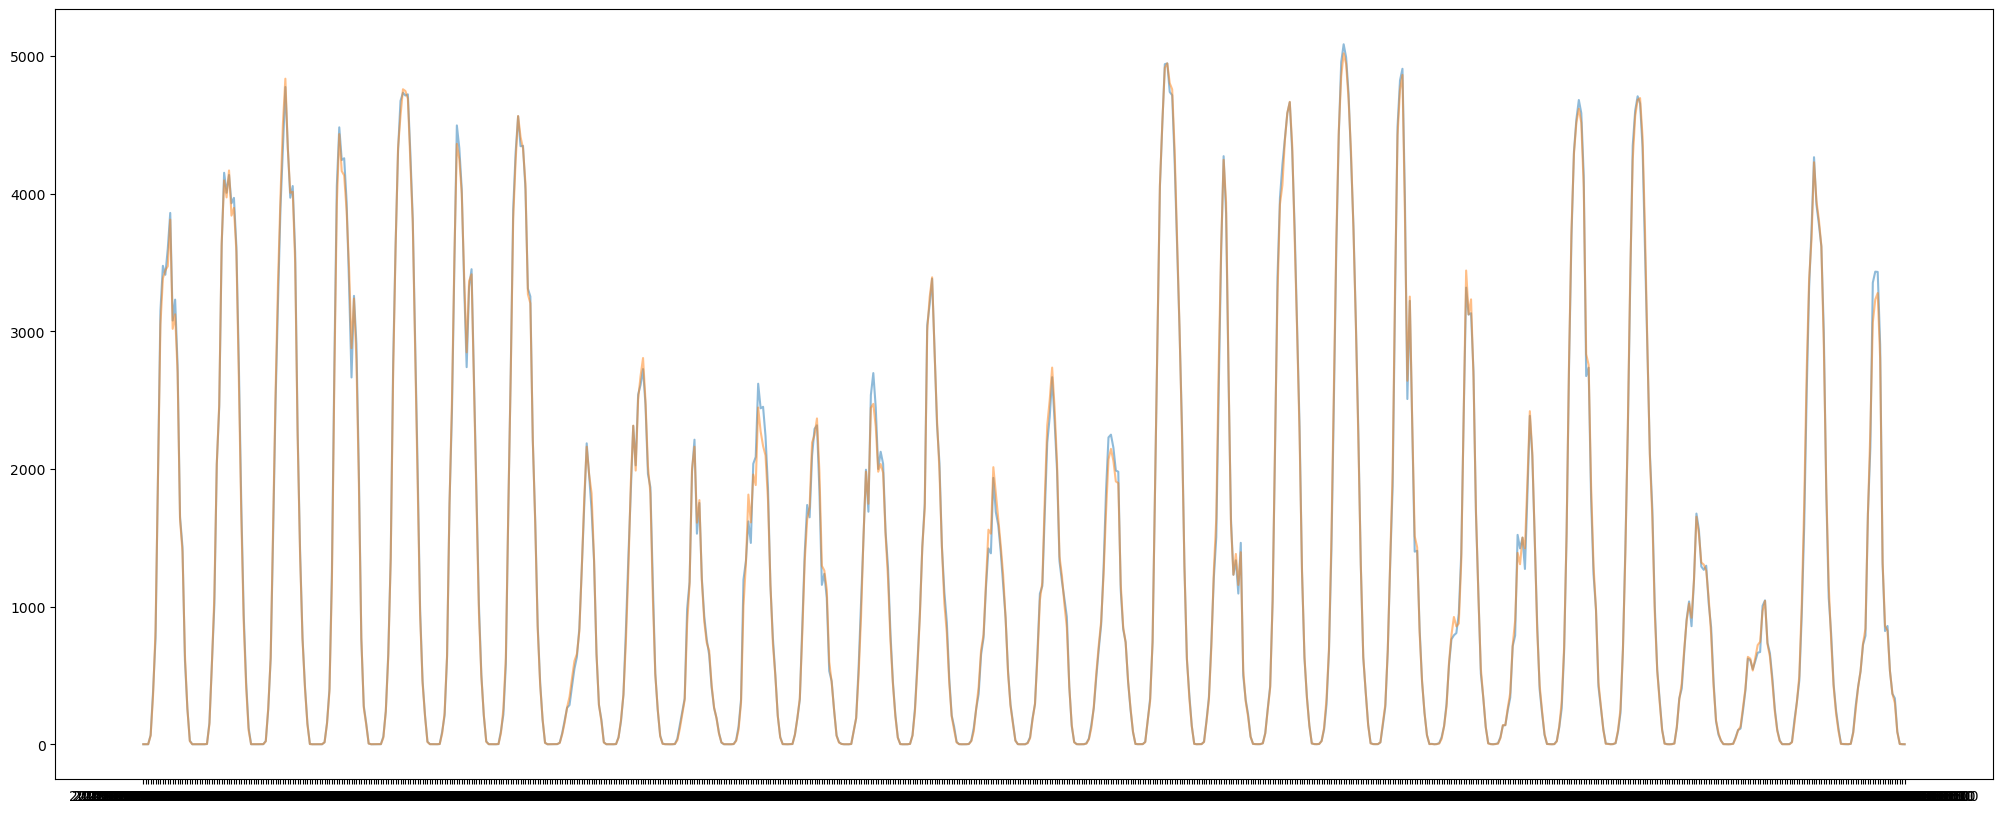

In [53]:
location = "A"
model1 = plot_data3.copy()
model2 = plot_data5.copy()
plt.figure(figsize=(25, 10))
plt.plot(model1[model1.location == location]["date"], model1[model1.location == location]["y"], alpha=0.5)
plt.plot(model2[model2.location == location]["date"], model2[model2.location == location]["y"], alpha=0.5)
print("Location error:")
print(mean_absolute_error(model1[model1.location == location]["y"], model2[model2.location == location]["y"]))
print("Total error:")
print(mean_absolute_error(model1["y"], model2["y"]))


In [63]:

# Current best model

# weighted_pred = prediction_df_scaled_df.copy()
# weighted_pred[0] = prediction_df_scaled_df[0] * 0.4 + best_pred["prediction"] * 0.6
# weighted_pred

# Weighing in tuned LightGBM model
weighted_pred = prediction_df_scaled_df.copy()
weighted_pred[0] = lgb_hypertune[0] * 0.3 + (prediction_df_scaled_df[0] * 0.4 + best_pred["prediction"] * 0.6) * 0.7
weighted_pred

,0
0,0.562497
1,0.628926
2,0.670610
3,64.348593
4,367.990104
...,...
2155,52.945333
2156,23.965789
2157,6.314080
2158,2.835286


In [64]:
resultframe = pd.DataFrame(columns = ["id", "prediction"])
resultframe["prediction"] = weighted_pred
resultframe['prediction'] = np.where(resultframe['prediction'] < 0, 0, resultframe['prediction'])
resultframe["id"] = range(len(resultframe))
resultframe.head()

,id,prediction
0,0,0.562497
1,1,0.628926
2,2,0.670610
3,3,64.348593
4,4,367.990104


In [65]:
import datetime


resultframe.to_csv("../data/results/"+ str(datetime.datetime.now()) + "-submission.csv", index=False)